# Assignment 1

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.*

*Note that this assignment was designed to run in the **Jupyter Notebook** environment.*

The assignment has three tasks:

- Task 1: Understanding the limitations of double-integrating acceleration time-series to obtain position time-series and exploring the efficacy of low-pass filter (LPF) in reducing noice.
- Task 2: Experimenting with sensor fusion algorithms to obtain acceleration in the global coordinate system while the sensor is in motion and assessing the associated challenges to gain insights into the complexity of the task.
- Task 3: Experimenting with sensor fusion algorithms to obtain acceleration in the global coordinate system while the sensor is moving randomly.

In [46]:
# Run some setup code for this notebook
import os
import copy
import numpy as np
import pandas as pd
from types import SimpleNamespace
from scipy.signal import find_peaks, resample, butter, filtfilt
from scipy.integrate import cumtrapz
from scipy.spatial.transform import Rotation as R

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from cs690r.data_utils import load_sensor_from_csv, load_mocap_from_tsv, trim_data 
from cs690r.plot_utils import plot_time_series, animate_trajectory, compare_trajectory

# The commands will allow the notebook to reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[`Attitude and Heading Reference Systems (AHRS)`](https://ahrs.readthedocs.io/en/latest/index.html) is a Python library for sensor fusion, specifically for estimating orientation from inertial measurement unit (IMU) data, which typically includes acceleration and angular velocity measurements.

To download and install the package, you can use the following command in their terminal or command prompt:

```bash
pip install ahrs
```

Refer to this [page](https://ahrs.readthedocs.io/en/latest/installation.html) for more detailed information about ahrs installation. 

Once you install the package, you can import and use the ahrs.filters module for sensor fusion algorithms in you Python scripts or Jupyter notebooks.

In [47]:
from ahrs.filters import *

In [48]:
# Define gravity constant
GRAVITY_CONSTANT = 9.80665

# Task 1
You can find the data for Task 1 in the "data" folder. In this task, a sensor equipped with accelerometer, gyroscope, and magnetometer was placed on a stationary horizontal surface. To facilitate this process, a function for loading sensor data from text files has been implemented for students. This function is located in the "cs690r.data_utils" module.

You can access the attributes of sensor data using the following code
```python
sample_rate = sensor_data.sample_rate # sampling rate of the sensor, 100Hz
acc = sensor_data.acc # acceleration, unit: m/s^2
gyr = sensor_data.gyr # angular velocity, unit: rad/s
mag = sensor_data.mag # magnetometer data, unit: a.u. (arbitrary units; normalized to earth field strength)

free_acc = sensor_data.free_acc # the sensor's manufacturer (Movella XSens) has its proprietary algorithm to estimate the gravity-free acceleration in the global coordinates
```

Please note that the data in the file is raw and unfiltered.

In [49]:
# Load stationary data
task1_sensor_file = os.path.join('data', 'task1_sensor_data.csv')
task1_sensor_data = load_sensor_from_csv(task1_sensor_file)

In [50]:
# Remove gravity from the z-axis, given that the sensor was placed stationary
task1_sensor_data.acc[:, 2] -= GRAVITY_CONSTANT

**Task 1.1**: 

1) Implement the `filtering_and_integrate` function provided below. In this function, use a 6th order Butterworth filter with a cut-off frequency of 8 Hz to low-pass filter the raw acceleration and angular velocity, respectively. Integrate the filtered acceleration to derive the velocity time-series, followed by band-pass filtering (2nd order Butterworth) with cut-off frequency between 0.1 Hz and 8 Hz to address integration drift and high-frequency noise. Repeat the integration and band-pass filtering process to the derived velocity time-series to get position time-series.

2) Apply `filtering_and_integrate` to `task1_sensor_data`. Specifically, double-integrate the acceleration time-series to obtain position time-series both **with and without filtering**.


**Hint**:

1) For integration, consider [`scipy.integrate.cumtrapz`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.cumtrapz.html) or [`scipy.integrate.cumulative_trapezoid`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.cumulative_trapezoid.html) for integration depending on the version of `scipy` you are using. You are also free to use other integration implementations you are familiar with.

2) For filtering, checkout `Filtering Example.ipynb` in this folder to learn how to design different types of filters.

In [51]:
# Exercise 1.1.1: Implement the `filtering_and_integrate` function provided below
def filtering_and_integrate(data, use_filter=True):
    '''
    Input Parameters
    ----------
    data : sensor data object
        To access the acceleration, use:
        acc = data.acc

    use_filter : boolean
        If use_filter is set to True,
        low-pass and band-pass filters will be applied to the data
        
    Output Parameters
    -----------
    data : sensor data object with filtered data
        data.acc: filtered acceleration
        data.vel: integrated, filtered velocity
        data.pos: integrated, filtered position
        data.gyr: filtered angular velocity
    '''
    data = copy.deepcopy(data)

    # Get acceleration
    acc = data.acc.copy()
    
    # Get angular velocity
    gyr = data.gyr.copy()
    
    # Get the sampling rate of the sensor
    sample_rate = data.sample_rate

    ####################################################################
    # TODO: Define low-pass filter and band-pass filter
    # apply the filters on the sensor acceleration and angular velocity
    # if use_filter is True
    # integrate the acceleration to get velocity and position
    vel = np.zeros((acc.shape[0]-1,acc.shape[1]))
    pos = np.zeros((vel.shape[0]-1,vel.shape[1]))

    for i in range(3):
        if(use_filter):
            cutoff = 8
            b, a = butter(6,cutoff/(sample_rate/2),btype='lowpass')
            acc[:,i] = filtfilt(b,a,acc[:,i])
            gyr[:,i] = filtfilt(b,a,gyr[:,i])
        
        vel[:,i] = cumtrapz(acc[:,i],dx=1/sample_rate)

        if(use_filter):
            low_cutoff = 0.1  # Lower cutoff frequency in Hz
            high_cutoff = 8  # Upper cutoff frequency in Hz

            # Design Butterworth band-pass filter
            b, a = butter(2, [low_cutoff / (sample_rate / 2), high_cutoff / (sample_rate / 2)], btype='bandpass')
            vel[:,i] = filtfilt(b,a,vel[:,i])

        pos[:,i] = cumtrapz(vel[:,i],dx=1/sample_rate)

        if(use_filter):
            low_cutoff = 0.1  # Lower cutoff frequency in Hz
            high_cutoff = 8  # Upper cutoff frequency in Hz

            # Design Butterworth band-pass filter
            b, a = butter(2, [low_cutoff / (sample_rate / 2), high_cutoff / (sample_rate / 2)], btype='bandpass')
            pos[:,i] = filtfilt(b,a,pos[:,i])


    
    ####################################################################
    
    # Save acceleration, velocity, position, and angular velocity
    data.acc = acc
    data.vel = vel
    data.pos = pos
    data.gyr = gyr
    return data

In [52]:
# Exercise 1.1.2: Apply `filtering_and_integrate` on task1_sensor_data 
# with and without filters
filt_data = filtering_and_integrate(task1_sensor_data)
no_filt_data = filtering_and_integrate(task1_sensor_data,use_filter=False)

/tmp/ipykernel_7486/344844080.py:48: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  vel[:,i] = cumtrapz(acc[:,i],dx=1/sample_rate)
/tmp/ipykernel_7486/344844080.py:58: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  pos[:,i] = cumtrapz(vel[:,i],dx=1/sample_rate)


**Task 1.2**

1) Apply `plot_time_series` (located in plot_utils.py) to generate 1D time series plots for acceleration, velocity, and position in each scenario (with and without filtering).

2) Animate the position time-series derived from with/without a low-pass filter using the provided `animate_trajectory` (located in plot_utils.py).

Even though the sensor was placed on a horizontal surface, the raw unfiltered acceleration does not seem to be perfectly zero due to imperfect calibration and inherent sensor noise. Integrating the raw unfiltered acceleration to obtain velocity and position may cause significant drift over time. However, utilizing a low-pass filter and a band-pass filter can effectively mitigate this drift.

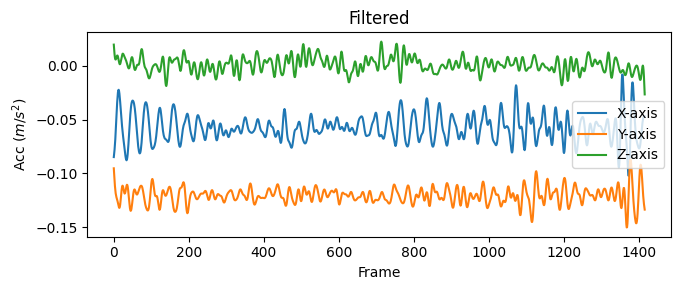

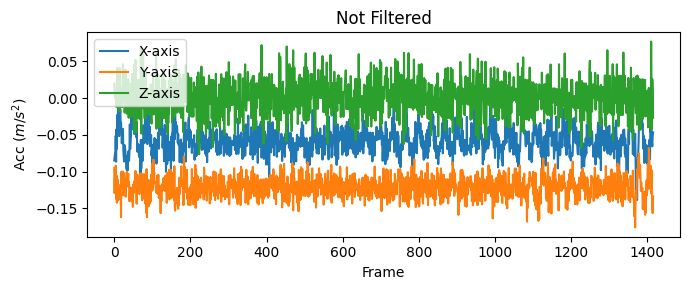

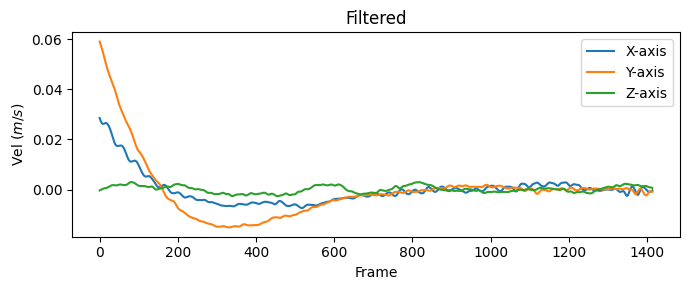

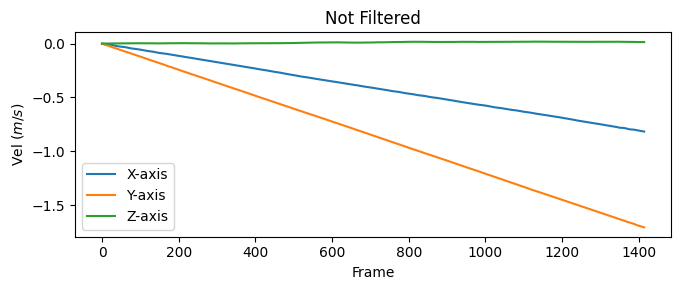

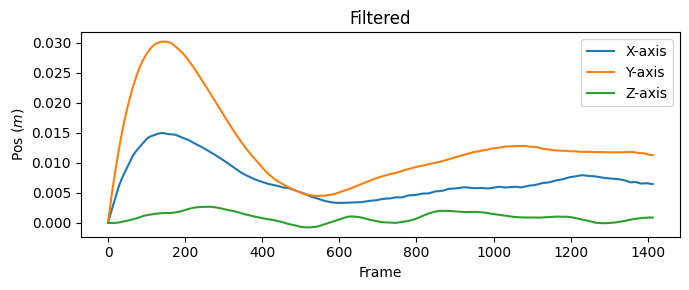

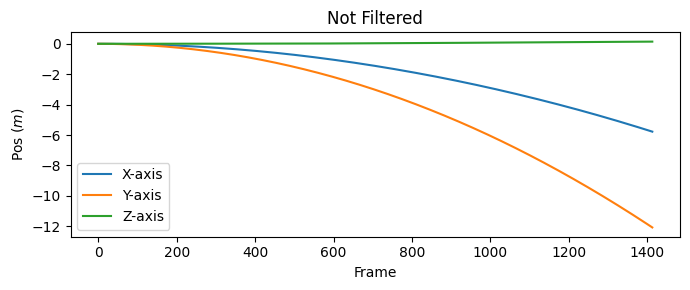

In [58]:
# Exercise 1.2.1: Plot 1D time series for acceleration, velocity, and position
# in each scenario (i.e. with/without filtering) 
plot_time_series(filt_data.acc,'acc','Filtered') 
plot_time_series(no_filt_data.acc,'acc','Not Filtered')
plot_time_series(filt_data.vel,'vel','Filtered') 
plot_time_series(no_filt_data.vel,'vel','Not Filtered')
plot_time_series(filt_data.pos,'pos','Filtered') 
plot_time_series(no_filt_data.pos,'pos','Not Filtered')

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


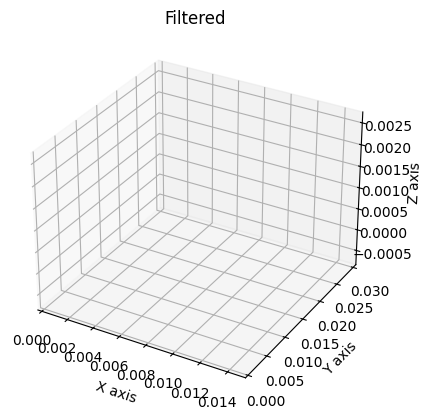

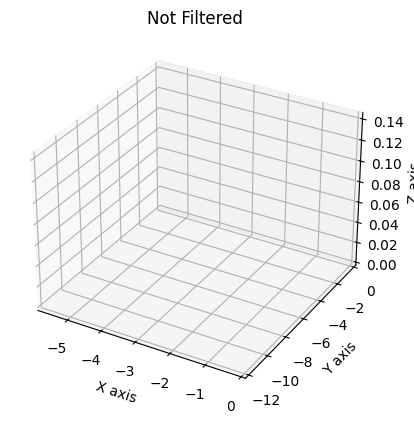

In [57]:
# Exercise 1.2.2: Animate the position time-series
# obtained with filtering and without filtering
filt_anim = animate_trajectory(filt_data.pos,'Filtered')
no_filt_anim = animate_trajectory(no_filt_data.pos,'Not Filtered')
filt_anim.save('filt.gif')
no_filt_anim.save('no_filt.gif')

I was unable to get the animations to show inline, but I was able to save them and add them to a new markdown block


![Filtered](filt.gif)
![Not Filtered](no_filt.gif)

# Task 2
In this task, an 9-axis inertial measurement unit (referred to as *sensor*) was moved along a rectangular trajectory within 3D space (i.e., the trajectory discussed in class). The sensor captured the three-axis accelerometer, three-axis gyroscope, and three-axis magnetometer time-series. Moreover, a reflective marker was also placed on the sensor to capture the three-axis position time-series using a motion caption system (referred to as *mocap*). 

Note that we have used *hand clapping* to synchronize the mocap and sensor data.

You can find the data for Task 2 in the "data" folder. The sensor data were saved in `task_2_sensor_data.csv`, whereas the mocap data were saved in `task2_mocap_data.tsv`. You may use `load_sensor_from_csv` and `load_mocap_from_tsv` functions provided in `data_utils.py` to load the data.

You can access the attributes of mocap data by using the following code
```python
sample_rate = mocap_data.sample_rate # sampling rate of the mocap system, 150Hz
raw_pos = mocap_data.raw_pos # position, unit: m
```

Please note that the data in the files are raw and unfiltered.

In [ ]:
# Load sensor data
task2_sensor_file = os.path.join('data', 'task2_sensor_data.csv')
task2_sensor_data = load_sensor_from_csv(task2_sensor_file)

# Load mocap data
task2_mocap_file = os.path.join('data', 'task2_mocap_data.tsv')
task2_mocap_data = load_mocap_from_tsv(task2_mocap_file)

Run the following code to visualize the raw acceleration and angular velocity captured by the sensor. Note that the data collector clapped multiple times before and after the data collection, resulting in large peaks in the data.

In [ ]:
# Plot the sensor's raw acceleration and angular velocity
n_rows = 2
n_cols = 1
row_sz = 3
col_sz = 7

%matplotlib notebook
fig = plt.figure(figsize=(n_cols*col_sz, n_rows*row_sz))
ax = fig.add_subplot(211)
ax.plot(task2_sensor_data.acc)
ax.set_xlabel('Frame')
ax.set_ylabel('Acc ($m/s^2$)')
ax.set_title('Sensor raw acceleration')
ax.legend(['X-axis', 'Y-axis', 'Z-axis'])

ax = fig.add_subplot(212)
ax.plot(task2_sensor_data.gyr)
ax.set_xlabel('Frame')
ax.set_ylabel('Angular vel ($rad/s$)')
ax.set_title('Sensor raw angular velocity')
ax.legend(['X-axis', 'Y-axis', 'Z-axis'])
fig.tight_layout()
plt.show()

**Task 2.1**

1) Implement the `filtering_and_gradient` function provided below. In this function, use a 6th order Butterworth filter with a cut-off frequency of 8 Hz to low-pass filter the raw position captured by the mocap system. Compute the gradient of the filtered position to derive the velocity time-series, followed by the same low-pass filter. Repeat the process of taking gradient and low-pass filtering to the velocity times-series to acquire acceleration time-series.

2) Apply `filtering_and_gradient` to `task2_mocap_data`. 

3) Apply `filtering_and_integrate` from Task 1 to `task2_sensor_data`.

**Hint**

1) For gradient, you can use [`numpy.gradient`](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html). You are also free to use other integration implementations you are familiar with.

In [ ]:
# Exercise 2.1.1 Implement the `filtering_and_gradient` function provided below
def filtering_and_gradient(data):
    '''
    Input Parameters
    ----------
    data : mocap data object
        To access the position, use:
        pos = data.pos
        
    Output Parameters
    -----------
    data : mocap data object with filtered data
        data.pos: filtered position
        data.vel: filtered velocity
        data.acc: filtered position
    '''
    data = copy.deepcopy(data)
    
    # Get raw position
    pos = data.pos.copy()
    
    # Get the sampling rate of the sensor
    sample_rate = data.sample_rate
    
    ####################################################################
    # TODO: Define low-pass filter
    # apply the filters on the data
    # take the gradient of the position to get velocity and acceleration
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    ####################################################################
    
    # Save filtered acceleration, velocity, and position
    data.pos = pos
    data.vel = vel
    data.acc = acc
    return data

In [ ]:
# Exercise 2.1.2: Apply `filtering_and_gradient` on task2_mocap_data 


In [ ]:
# Exercise 2.1.3: Apply `filtering_and_integrate` on task2_sensor_data


**Task 2.2**


In this task, you will delve into synchronizing data captured from disparate sensing systems. Variations in sampling rates or other factors often introduce discrepancies in the collected data. To facilitate synchronization, the data collector performed multiple claps while holding the sensor (which was attached with a mocap marker) before and after data collection. This resulted in large peaks in acceleration, as shown in our previous plots. Leveraging these claps, we can align different data by trimming segments between the claps and resampling to a uniform sampling rate.

1) Run the provided code to trim both sensor and mocap data.

2) Implement the `resampling_mocap` function. In the function, use [`scipy.signal.resample`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html) to resample the mocap acceleration, velocity, and position, in order to match the sampling rate of the sensor data. We opt to reduce the sampling rate of the mocap data to align with that of the sensor data, aiming to maintain data integrity (compared to upsampling the sensor data to match the mocap data, which entails data interpolation and may compromise integrity).

3) Apply `resampling_mocap` to `task2_mocap_data`.

In [ ]:
# Exercise 2.2.1: Run the provided code to trim both sensor and mocap data.
# The clapping indices were identified by manual inspection of the two data. 
sensor_start, sensor_end = 1183, 4431 # task 2
task2_sensor_data = trim_data(task2_sensor_data, sensor_start, sensor_end, 'sensor')

mocap_start, mocap_end = 1981, 6812 # task 2
task2_mocap_data = trim_data(task2_mocap_data, mocap_start, mocap_end, 'mocap')

In [ ]:
# Exercise 2.2.2: Implement the `resampling_mocap` function provided below
def resampling_mocap(data, num):
    '''
    Input Parameters
    ----------
    data : mocap data object
    
    num : int, the number of samples in the resampled signal
    
    Output Parameters
    ----------
    data : mocap data object with resampled pos, vel and acc
    '''
    data = copy.deepcopy(data)
    
    ####################################################################
    # TODO: resample acceleration, velocity, and position
    
    
    
    ####################################################################
    
    return data

In [ ]:
# Exercise 2.2.3: Apply `resampling_mocap` to `task2_mocap_data`.


**Task 2.3**

This task will demonstrate the process of fusing acceleration and angular velocity data collected in the sensor's coordinate system to estimate the sensor's orientation in the global coordinate system. Once the orientation is determined, this information can be utilized to align or rotate the sensor to the global coordinate system.

1) Implement the `fuse_and_rotate` function. Firstly, select a method from `ahrs` to estimate the sensor's orientation. Secondly, utilize the estimated orientation to transform the acceleration and angular velocity from the sensor's coordinate system to the global coordinates. Thirdly, remove gravity from the vertical axis of the global coordinate acceleration. Finally, apply `filtering_and_integrate` from Task 1 to the transformed gravity-free, global-coordinate acceleration to derive velocity and position time-series in the global coordinates.

2) Apply `fuse_and_rotate` to `task2_sensor_data` to obtain acceleration, velocity, and position time-series in the global coordinates.

3) Utilize `compare_trajectory` to visualize the acceleration, velocity, and position from both the sensor and mocap systems in the global coordinates.

**Hint**

1) You can choose from the following methods provided by AHRS to estimate sensor orientation. The methods shown in the table below assume that the Z-axis of the global coordinate system aligns with gravity. Therefore, you can easily eliminate gravity from the transformed acceleration.

| Fusion Method                                                           | Orientatio<br>Representation | What to set inverse in<br>`R.from_quat().apply()` |
|-------------------------------------------------------------------------|----------------------------|------------------------------------------------|
| [AQUA](https://ahrs.readthedocs.io/en/latest/filters/aqua.html)         | global -> local            | True                                           |
| [Madgwich](https://ahrs.readthedocs.io/en/latest/filters/madgwick.html) | local -> global            | False                                          |
| [Mahony](https://ahrs.readthedocs.io/en/latest/filters/mahony.html)     | local -> global            | False                                          |

Here's an example of sensor orientation estimation using `AQUA` from `ahrs`. Suppose you have acceleration data `acc` in m/s^2 and angular velocity data `gyr` in rad/s, sampled at a frequency of `sample_freq` Hz. To estimate the orientation, you can follow these steps:

```python
ahrs_filter = AQUA(acc=acc, gyr=gyr, frequency=sample_freq) # define sensor fusion method
orientation = ahrs_filter.Q # access the orientation
```

The `orientation` calculated by `AQUA` represents the global to local transformation, whereas for Madgwick and Mahony, it represents the local to global transformation. You need to be careful with this difference when using them for future coordinate transformation.

2) For coordinate transformation, you can use [`scipy.spatial.transform.Rotation`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html). Assume the local acceleration captured in the sensor local frame is `local_acc` and the `orientation` transforms the data from the sensor local frame to the global frame. To perform transformation,

```python
orientation = orientation[:, [1, 2, 3, 0]] # the orientation calculated from ahrs has different form than what is required by R.from_quat

global_acc = R.from_quat(orientation).apply(local_acc, inverse=True) # inverse needs to be set to `True` because the orientation calcuated from AQUA represents the transformation from global coordinate system to the sensor coordinate system. For Madgwich and Mahony methods, `inverse` needs to be set to `False`.

global_acc[:, 2] -= GRAVITY_CONSTANT # remove gravity from Z-axis
```

In the code above, if `inverse` is specificed `True` in `R.from_quat().apply()`, the inverse of the rotation(s) is applied to the input vectors. You can refer to the table above for guidance on how to set up this parameter.

In [ ]:
# Exercise 2.3.1 Implement the `fuse_and_rotate` function
def fuse_and_rotate(local_data):
    '''
    Input Parameters
    ----------
    local_data : sensor data object in sensor's coordinates
    
    Output Parameters
    ----------
    global_data : transformed data object in global coordinates
        global_data.sample_rate: the synchornized sampling rate
        global_data.acc: global 3D accelerometer
        global_data.gyr: global 3D gyroscope
    '''
    local_data = copy.deepcopy(local_data)
    
    local_acc = local_data.acc
    local_gyr = local_data.gyr
    sample_rate = local_data.sample_rate
    
    ####################################################################
    # TODO: Calculate sensor orientation, then use orientation to 
    # transform acceleration and angular velocity from sensor local 
    # frame to global frame
    # Remove gravity from global acceleration
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    ####################################################################
    
    # Save the transformed data
    global_data = SimpleNamespace()
    global_data.sample_rate = local_data.sample_rate
    global_data.acc = global_acc
    global_data.gyr = global_gyr
    
    ####################################################################
    # TODO: Apply filtering_and_integrate to global data
    
    ####################################################################
    
    return global_data

In [ ]:
# Exercise 2.3.2: Apply `fuse_and_rotate` on `task2_sensor_data`


In [ ]:
# Exercise 2.3.3: Compare acceleration, velocity, and position 
# from sensor fusion algorithm and mocap system


**Task 2.4**

In this exercise, you will evaluate the performance of the `ahrs` algorithm both quantitatively and qualitatively.

1) Calculate the root mean square error (RMSE) and the normalized root mean square error (NRMSE) for acceleration, velocity, and position time-series obtained from your sensor fusion algorithm with the mocap data, respectively. NRMSE is obtained by normalizing the RMSE to the range of mocap data, so that the error can be represented in percentage (%). 

**When you calculate RMSE and NRMSE for the position time-series, make sure that both position time-series start at 0 (for fair comparison).**

This analysis will provide insights into the accuracy and reliability of your sensor fusion algorithm compared to the ground truth mocap data.

2) Create animations using `animate_trajectory` for the position time-series derived from the sensor fusion algorithm and captured by the mocap system, respectively. By visually comparing these animations, you can qualitatively assess how well the sensor fusion algorithm aligns with the mocap system in representing the sensor's movements.

In [ ]:
# Exercise 2.4.1: Calculate RMSE and NRMSE for acceleration, velocity, 
# and position time-series, respectively


In [ ]:
# Exercise 2.4.2: Animate the position time-series derived from the motion capture system (i.e., groundtruth)
%matplotlib notebook

In [ ]:
# Exercise 2.4.3: Animate the position time-series derived from the sensor fusion algorithm
%matplotlib notebook

**Task 2.5**

In this exercise, you will leverage the gravity-free acceleration data provided by the manufacturer Xsens, known for its accuracy in fusing multi-modal data to estimate sensor orientation and obtain acceleration in global coordinates. This will enable you to evaluate the manufacturer's algorithm performance and compare it with mocap data. Note that the sensor fusion algorithm by Xsens uses all nine-axis inertial data (accelerometer + gyroscope + magnetometer) compared to the AQUA algorithm that uses only six-axis data (accelerometer + gyroscope).

1) Apply the `filtering_and_integrate` function to the manufacturer gravity-free acceleration data to derive velocity and position time-series.

2) Utilize `compare_trajectory` to visualize the acceleration, velocity, and position from both the manufacturer's gravity-free data and mocap systems in the global coordinates. 

3) Calculate the RMSE and NRMSE between the acceleration, velocity, and position time-series derived from the manufacturer gravity-free acceleration and the mocap system, respectively.

4) Generate animations for the position time-series derived from the gravity-free acceleration provided by the manufacturer.

In [ ]:
task2_gravity_free_data = SimpleNamespace()
task2_gravity_free_data.sample_rate = task2_sensor_data.sample_rate
task2_gravity_free_data.acc = task2_sensor_data.free_acc
task2_gravity_free_data.gyr = task2_sensor_data.gyr

In [ ]:
# Exercise 2.5.1: Apply the `filtering_and_integrate` function 
# to the manufacturer gravity-free acceleration data


In [ ]:
# Exercise 2.5.2: Compare acceleration, velocity, and position 
# from manufecturer and mocap system


In [ ]:
# Exercise 2.5.3: Calculate RMSE and NRMSE for acceleration, velocity, 
# and position time-series, respectively


In [ ]:
# Exercise 2.5.4: Animate the position time-series derived from manufecturer data
%matplotlib notebook

# Task 3
You can find the data for Task 3 in the "data" folder. In this task, a nine-axis IMU and a mocap marker was placed on a human subject's wrist, who performed some arbitrary, patternless, and random upper-limb movements (e.g., swinging the arm in the air randomly). The sensor data were saved in `task_3_sensor_data.csv`, and the mocap data were saved in `task3_mocap_data.tsv`.

In [ ]:
# Load sensor data
task3_sensor_file = os.path.join('data', 'task3_sensor_data.csv')
task3_sensor_data = load_sensor_from_csv(task3_sensor_file)

# Load mocap data
task3_mocap_file = os.path.join('data', 'task3_mocap_data.tsv')
task3_mocap_data = load_mocap_from_tsv(task3_mocap_file)

The objective of Task 3 is to apply the same procedures (Task 2.1 - 2.5) to this dataset, aiming to assess the algorithm's capability to handle entirely unpredictable movements that simulate daily scenarios.

1) Apply `filtering_and_gradient` to `task3_mocap_data`. 

2) Apply `filtering_and_integrate` to `task3_sensor_data` with filtering. 

3) Synchronization and resampling. Trim the sensor data and mocap between the provided clapping indices. Then, apply `resampling_mocap` to resample to the mocap data to match the sampling rate of sensor data.

4) Apply `fuse_and_rotate` on the sensor data.

5) Utilize `compare_trajectory` to visualize the acceleration, velocity, and position from both the sensor and mocap systems in the global coordinates.

6) Calculate the RMSE and NRMSE between the acceleration, velocity, and position time-series derived from the `ahrs` and the mocap system, respectively.

7) Create animations using `animate_trajectory` for the position time-series derived from the sensor fusion algorithm and captured by the mocap system, respectively.

8) Repeat Task 2.5 with data provided by the manufecturer in `task3_sensor_data`.

In [ ]:
# Exercise 3.1: Apply `filtering_and_gradient` to `task3_mocap_data`


In [ ]:
# Exercise 3.2: Apply `filtering_and_integrate` to `task3_sensor_data` with filtering. 


In [ ]:
# Exercise 3.3: Synchronization and resampling
sensor_start, sensor_end = 918, 5198 # task 3
task3_sensor_data = trim_data(task3_sensor_data, sensor_start, sensor_end, 'sensor')

mocap_start, mocap_end = 1300, 7719 # task 3
task3_mocap_data = trim_data(task3_mocap_data, mocap_start, mocap_end, 'mocap')

# TODO: Apply `resampling_mocap` to resample to the mocap data


In [ ]:
# Exercise 3.4: Apply `fuse_and_rotate` on the sensor data.


In [ ]:
# Exercise 3.5: Compare acceleration, velocity, and position from sensor fusion algorithm
# and mocap system


In [ ]:
# Exercise 3.6: Calculate RMSE and NRMSE obtained from your sensor fusion algorithm with the mocap data


In [ ]:
# Exercise 3.7: Animate the position time-series captured by the mocap system
%matplotlib notebook

In [ ]:
# Exercise 3.7: Animate the position time-series derived from the sensor fusion algorithm
%matplotlib notebook

In [ ]:
task3_gravity_free_data = SimpleNamespace()
task3_gravity_free_data.sample_rate = task3_sensor_data.sample_rate
task3_gravity_free_data.acc = task3_sensor_data.free_acc
task3_gravity_free_data.gyr = task3_sensor_data.gyr

In [ ]:
# Exercise 3.8: Repeat Task 2.5 with data provided by the manufecturer in `task3_sensor_data`.
# TODO: apply filtering_and_integrate on the manufecturer data


In [ ]:
# TODO: Compare acceleration, velocity, and position 
# from manufecturer and mocap system


In [ ]:
# TODO: Calculate RMSE and NRMSE for acceleration, velocity, 
# and position time-series, respectively


In [ ]:
# TODO: Animate the position time-series derived from manufecturer data
%matplotlib notebook